In [1]:
% matplotlib inline

import numpy as np
import numpy.ma as ma
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.basemap import Basemap, cm
import seawater as sw

import MITgcmutils as mit
from MITgcmutils import cs

from matplotlib import rcParams, rc
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# work out the indexing for beg/end 1999
# indices start in 1992 to end of 1999

it1=(365*5+366*2)*24
it2=it1+(365*24)

nz=23

# set up grid
delz=[10.,10.,15.,20.,20.,25.,35.,50.,75., 100.,150.,200.,275.,350.,415.,450.,500., 500.,500.,500.,500.,500.,500.]
depth=np.cumsum(delz)

lon = np.arange(.5,360.5, 1)
lat= np.arange(-79.5, 80.5, 1)

it=1
nt=365
nx=360
ny=160


In [3]:
# get mid-depth of grid cell
depthm = np.zeros(len(depth))
depthm[0]=depth[0]/2

for k in range(1,nz):
    depthm[k]=depthm[k-1]+0.5*delz[k]

depthgrid=np.zeros((23, 160, 360))
depthgrid[0,:,:]=5;

for k in range(1, nz):
    depthgrid[k,:,:]=depthm[k]

latgrid=np.zeros((23, 160, 360))
for j in range(0, ny):
    latgrid[:,j,:]=lat[j];

depthmax = np.fromfile('/Users/sclayton/Documents/darwin_model/eg_grid/Depth.data', dtype = '>f')
depthmax = np.transpose(depthmax.reshape(360, 160))
 
rc = np.fromfile('/Users/sclayton/Documents/darwin_model/eg_grid/RC.data', dtype = '>f')*-1

HFCR = np.fromfile('/Users/sclayton/Documents/darwin_model/eg_grid/HFacC.data', dtype = '>f')
HFCR = HFCR.reshape(23, 160, 360)[0,:,:]


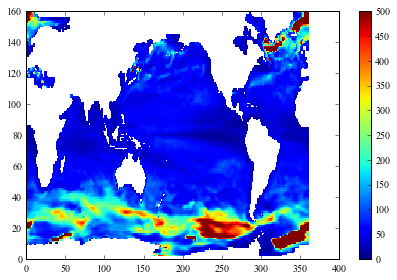

In [81]:
its = range(it1,it2,24)
zmld = np.zeros((len(its),ny,nx))

i = 0
for it in its:
    
    # read in temperature and salinity
    #print it
    salt = np.fromfile('/Users/sclayton/Google Drive/work/comparison/data/CRphysics/DDsalt/DDsalt.%010d.data' % it, dtype = '>f')
    salt = salt.reshape(23, 160, 360)
    theta = np.fromfile('/Users/sclayton/Google Drive/work/comparison/data/CRphysics/DDtheta/DDtheta.%010d.data' % it , dtype = '>f')
    theta = theta.reshape(23, 160, 360)
    
    # get pressure for each depth
    
    # calculate density using the seawater-1.0.3 package (UNESCO)
    dens = sw.dens(salt,theta, 0.)
    surfdens = dens[0,:,:]
    critdens = surfdens + 0.125


    for y in range(ny):
        for x in range(nx):
                
        # for k in range(kmax):
        # now need to find rho1 and rho2 that bound rhocrit and then interpolate to find mld
                
            r = (dens[:,y,x] > critdens[y,x]).nonzero()
               
            if len(r[0]) == 0:
                zmld[i,y,x] += depthmax[y,x]
            else:

                rho1 = dens[(r[0][0]-1),y,x]
                rho2 = dens[(r[0][0]),y,x]
                z1 = rc[(r[0][0]-1)]
                z2 = rc[(r[0][0])]
                
                zmld[i,y,x] += z1 + ((critdens[y,x] - rho1)*(z2 - z1))/(rho2 - rho1)
#                print('zmld', zmld[y,x])
    
    if 1 % 10 == 0:
        print i
    i += 1

    # mld.astype('>f4').tofile('MLD.1999.{0:03d}.001.data'.format(its,itile+1))



mld_mask = ma.masked_where(HFCR == 0, np.nanmean(zmld, 0), copy=False)
plt.pcolor(mld_mask, shading = 'flat', vmin = 0, vmax = 500)
plt.colorbar()
plt.show()

In [82]:
# get monthly averages

monthly=np.zeros((12, 160, 360))
days=[0,31,28,31,30,31,30,31,31,30,31,30,31]
startday=(np.cumsum(days)+1)[0:12]
endday=np.cumsum(days)[1:13]

for m in range(12):
    beg = startday[m]-1
    fin = endday[m]-1
    tmp = zmld[beg:fin,:,:]
    print np.shape(tmp)
    monthly[m,:,:] = np.nanmean(tmp, 0)
    del tmp
    print m
        

(30, 160, 360)
0
(27, 160, 360)
1
(30, 160, 360)
2
(29, 160, 360)
3
(30, 160, 360)
4
(29, 160, 360)
5
(30, 160, 360)
6
(30, 160, 360)
7
(29, 160, 360)
8
(30, 160, 360)
9
(29, 160, 360)
10
(30, 160, 360)
11


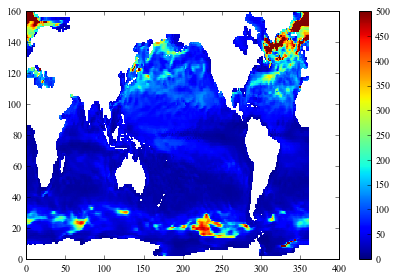

In [83]:
mld_mask = ma.masked_where(HFCR == 0, monthly[0,:,:], copy=False)
plt.pcolor(mld_mask, shading = 'flat', vmin = 0, vmax = 500)
plt.colorbar()
plt.show()